In [26]:
import sys
IN_COLAB = 'google.colab' in sys.modules

In [27]:
import json
from typing import NamedTuple
import base64
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [28]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [29]:
def get_config_collab(url):
    return json.loads(requests.get(url).text)

def get_config_local(filename):
    with open(filename) as f:
        raw = json.load(f)
    return raw

def load_config(filename):
    if IN_COLAB:
        return get_config_collab(f'https://raw.githubusercontent.com/Quick-One/Learning_AI-ML/main/MNIST_NN/{filename}')
    return get_config_local(filename)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device")

Using 'cuda' device


<hr>

### Loading the MNIST Dataset


In [31]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


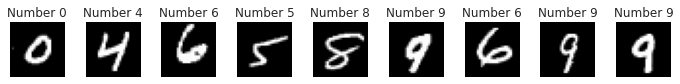

In [32]:
figure = plt.figure(figsize=(12, 1))
cols, rows = 9, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Number {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

<hr>

In [33]:
class NeuralNetwork(nn.Module):
    def __init__(self, linear_relu_stack : nn.Sequential):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = linear_relu_stack

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [34]:

def train_loop(dataloader, model, loss_fn, optimizer, m):  
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_train_loop(dataloader, model, loss_fn, m):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Training Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    m.error_training.append(test_loss)



def test_loop(dataloader, model, loss_fn, m):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    m.error_test.append(test_loss)


<hr>

In [35]:
class Model(NamedTuple):
    name: str
    learning_rate: float
    batch_size: int
    epochs: int
    hidden_layers: list
    error_test : list
    error_training :list

    def constructor(self):
        layer_size = self.hidden_layers.copy()
        layer_size.insert(0, 28 * 28)
        layer_size.append(10)

        layers = []
        for i in range(len(layer_size)-2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_size[-2], layer_size[-1]))

        linear_stack = nn.Sequential(*layers)
        return NeuralNetwork(linear_stack)


def load_models(config_dict: str) -> list:
    l = []
    for model_name, param in config_dict.items():
        error_test = []
        error_training = []
        m = Model(
            name=model_name,
            learning_rate=param['learning_rate'],
            batch_size=param['batch_size'],
            epochs=param['epochs'],
            hidden_layers=param['hidden_layers'],
            error_test=error_test,
            error_training=error_training
        )
        l.append(m)
    return l


<hr>

In [36]:
def train_models(config_dict):
    models = []
    for m in load_models(config_dict):
        models.append(m)
    for m in models:
        print(f'Training {m.name}')
        model = m.constructor().to(device)
        train_dataloader = DataLoader(training_data, batch_size=m.batch_size)
        test_train_dataloader = DataLoader(training_data, batch_size=m.batch_size)
        test_dataloader = DataLoader(test_data, batch_size=m.batch_size)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=m.learning_rate)

        for t in range(m.epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_dataloader, model, loss_fn, optimizer, m)
            test_train_loop(test_train_dataloader, model, loss_fn, m)
            test_loop(test_dataloader, model, loss_fn, m)
    return models

In [37]:
def visualise_model_perf(models : list, title = 'TITLE'):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    for m in models:
        epochs = m.epochs
        ax.plot(range(1, epochs+1), m.error_test, label = m.name)
    ax.set_title(title)
    ax.set_xlabel("Number of Epochs")
    ax.set_ylabel("Average Error")
    ax.legend()
    return fig, ax

<hr>

In [ ]:
models = train_models(load_config('layers.json'))

Training 1layers
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 68.2%, Avg loss: 2.072157 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 74.8%, Avg loss: 1.771911 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 78.0%, Avg loss: 1.433217 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 80.7%, Avg loss: 1.147190 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.946314 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.810702 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.716640 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.648641 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.597546 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.557898 

Epoch 11
-------------------------------
Test Error: 
 Accurac

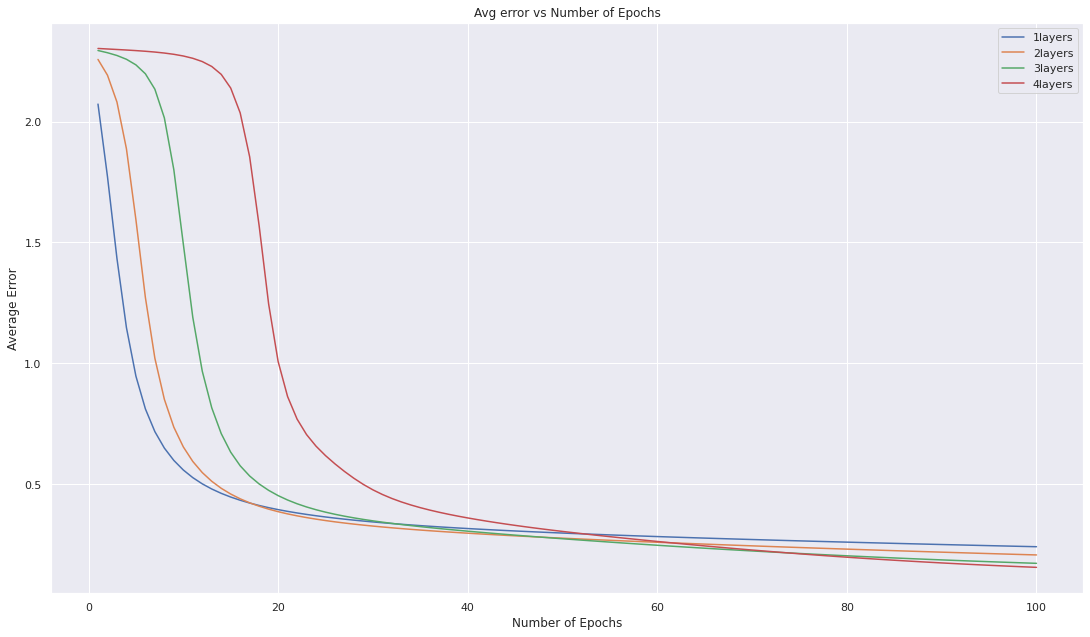

In [ ]:
visualise_model_perf(models, title='Avg error vs Number of Epochs');

### Demonstrating Model fitting

In [40]:
models = train_models(load_config('overfitting_demo.json'))

Training model
Epoch 1
-------------------------------
Training Error: 
 Accuracy: 16.8%, Avg loss: 2.293055 

Test Error: 
 Accuracy: 16.7%, Avg loss: 2.292735 

Epoch 2
-------------------------------
Training Error: 
 Accuracy: 20.0%, Avg loss: 2.283338 

Test Error: 
 Accuracy: 20.0%, Avg loss: 2.282843 

Epoch 3
-------------------------------
Training Error: 
 Accuracy: 27.3%, Avg loss: 2.270730 

Test Error: 
 Accuracy: 27.2%, Avg loss: 2.269983 

Epoch 4
-------------------------------
Training Error: 
 Accuracy: 38.0%, Avg loss: 2.252704 

Test Error: 
 Accuracy: 38.4%, Avg loss: 2.251581 

Epoch 5
-------------------------------
Training Error: 
 Accuracy: 47.4%, Avg loss: 2.224827 

Test Error: 
 Accuracy: 48.5%, Avg loss: 2.223154 

Epoch 6
-------------------------------
Training Error: 
 Accuracy: 55.0%, Avg loss: 2.178210 

Test Error: 
 Accuracy: 55.4%, Avg loss: 2.175639 

Epoch 7
-------------------------------
Training Error: 
 Accuracy: 60.1%, Avg loss: 2.093445 

T

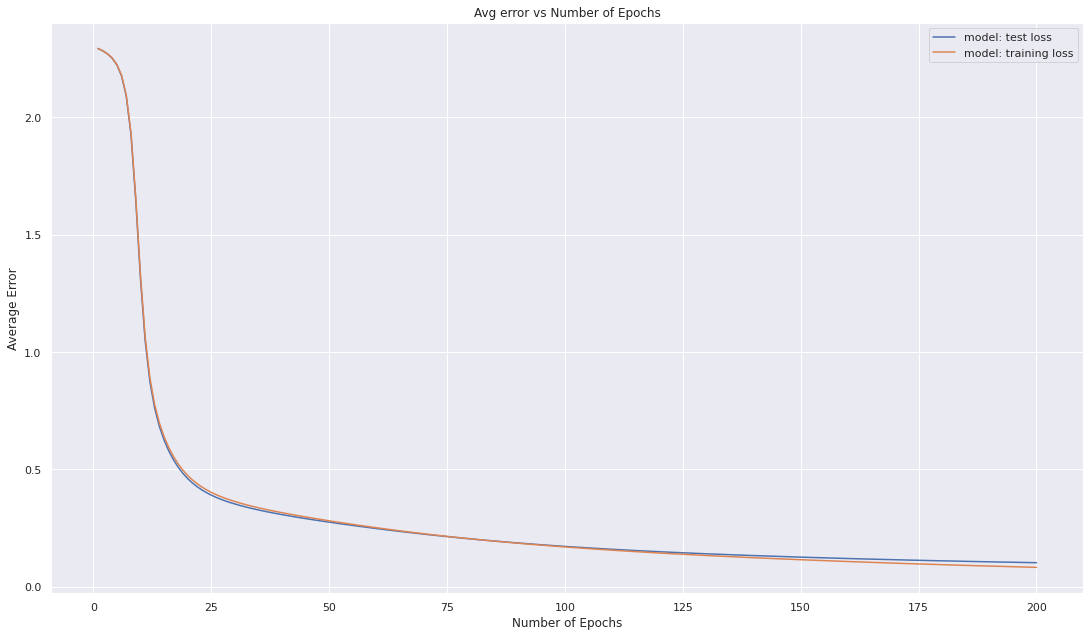

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
for m in models:
    epochs = m.epochs
    ax.plot(range(1, epochs+1), m.error_test, label = f"{m.name}: test loss")
    ax.plot(range(1, epochs+1), m.error_training, label = f"{m.name}: training loss")
ax.set_title("Avg error vs Number of Epochs")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Average Error")
ax.legend()

<hr>

In [ ]:
models = train_models(load_config('batch_size.json'))

In [ ]:
visualise_model_perf(models, title='Avg error vs Number of Epochs');